In [84]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [85]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [86]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [87]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [88]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [89]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [90]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [91]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session

session = Session(engine)

# Exploratory Precipitation Analysis

In [92]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"Most Recent Date: {most_recent_date[0]}")

Most Recent Date: 2017-08-23


Most recent date: 2017-08-23 00:00:00
Date one year ago: 2016-08-23 00:00:00
         date  precipitation
0  2016-08-24           0.08
1  2016-08-24           2.15
2  2016-08-24           2.28
4  2016-08-24           1.22
5  2016-08-24           2.15


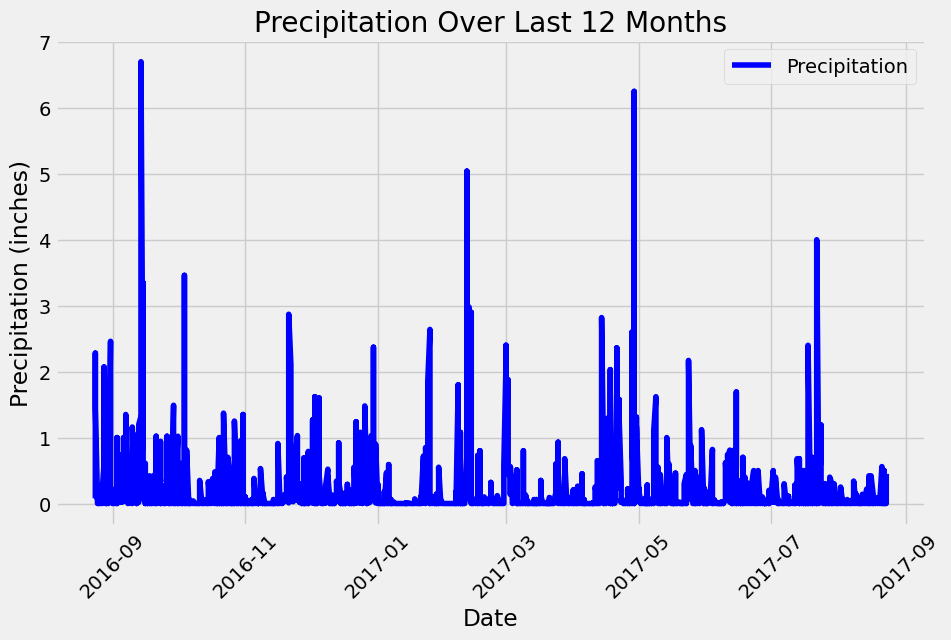

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

print(f"Most recent date: {most_recent_date}")
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

precip_df = precip_df.dropna()

print(precip_df.head())

# Sort the dataframe by date
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df = precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precip_df['date'], precip_df['precipitation'], color='blue', label='Precipitation')
plt.title('Precipitation Over Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [94]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df['precipitation'].describe()

print(precip_summary)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [95]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"Total Number of Stations: {total_stations}")

Total Number of Stations: 9


In [96]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [97]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]  # First element's station ID
print(f"Most Active Station ID: {most_active_station}")

# Query for the lowest, highest, and average temperature
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Extract the values from the tuple
lowest_temp, highest_temp, avg_temp = temp_stats[0]

# Display the results
print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Most Active Station ID: USC00519281
Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


Date One Year Ago: 2016-08-23 00:00:00


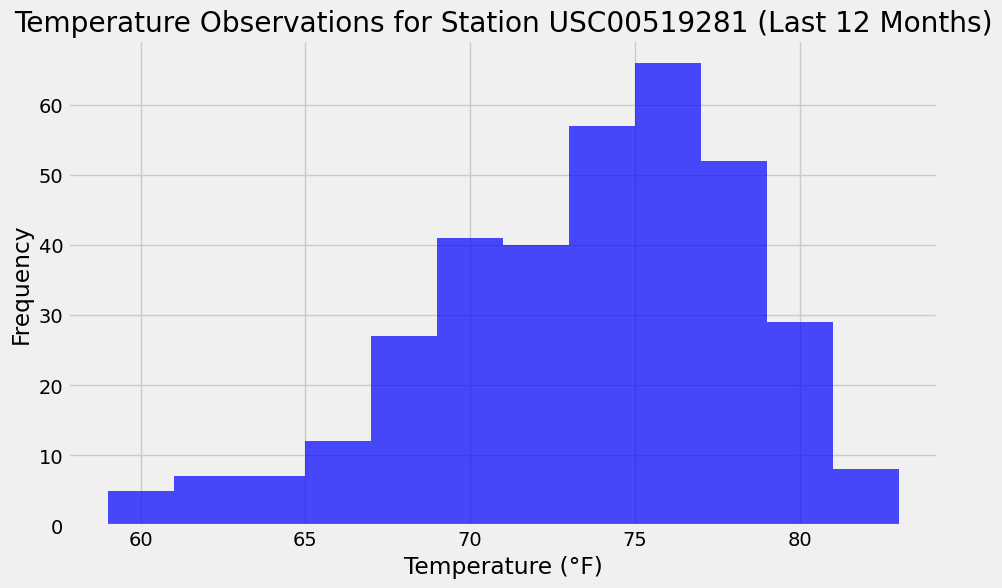

In [98]:
# Calculate the date one year ago from the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

print(f"Date One Year Ago: {one_year_ago}")

# Get the most active station ID (assuming from previous query)
most_active_station = active_stations[0][0]

# Query the last 12 months of temperature observation data for the most active station
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a list of temperatures
temperatures = [temp[0] for temp in tobs_data]

# Plot the temperature observations as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [99]:
# Close Session
session.close()